# Capstone Project Submission

Student name: Fernando Aguilar Islas<br>
Student pace: Part-Time<br>
Scheduled project review date/time: Tuesday, December 17, 2019 - 18:30 hrs<br>
Instructor name: Jeff Herman<br>
Blog post URL:

# Predicting Sovereign Credit Ratings using The Worldwide Governance Indicators (WGI)
## 1. Introduction
I had the opportunity to attend a hackathon at The Wolrd Bank and got to know first-hand about their mission: "to achieve the twin goals of ending extreme poverty and building shared prosperity". After beign separated into teams, my team got assigned the task to predict loan repayment risk using solely country governance indicators developed by The World Bank. During the assigned time, we mostly accomplished realising how hard assessing risk was for The World Bank when considering loan repayment risk from its member countries, especifically developing ones with precarious financial systems. At the end, we were asked what would we do given more time to develop a full feldged roject. I took on the changellenge and started working on this project.
## 2. Data
In this project, I will be using The Worldwide Governance Indicators (WGI) as model features and historical sovereign ratings since 2014 as the target variable. The Worldwide Governance Indicators (WGI) project reports aggregate and individual governance indicators for over 200 countries and territories over the period 1996–2018, for six dimensions of governance:
- Voice and Accountability
- Political Stability and Absence of Violence
- Government Effectiveness
- Regulatory Quality
- Rule of Law
- Control of Corruption

These aggregate indicators combine the views of a large number of enterprise, citizen and expert survey respondents in industrial and developing countries.  They are based on over 30 individual data sources produced by a variety of survey institutes, think tanks, non-governmental organizations, international organizations, and private sector firms. Governance consists of the traditions and institutions by which authority in a country is exercised.  This includes the process by which governments are selected, monitored and replaced; the capacity of the government to effectively formulate and implement sound policies; and the respect of citizens and the state for the institutions that govern economic and social interactions among them.[source: https://info.worldbank.org/governance/wgi/]

Sovereign credit rating, is an evaluation made by a credit rating agency and evaluates the credit worthiness of the issuer (country or government) of debt. The credit rating is used by individuals and entities that purchase debt by governments to determine the likelihood that will pay its debt obligations.[source: https://countryeconomy.com/ratings]

## 3. Project Framework and Methodology

Throughout the project, I will use the OSEMiN framework: Obtain, Scrub, Explore, Model, and iNterpret. After obtaining the variables from their resective sources I will scrub them, looking for missing values, outiliers, and data transofrmations. I will cointinue to ecplore their distributions and extract some insight regarding country governance through time-series analysis and statistical testing. The predictive model will attempt to predict long-term sovereign credit rating using the country's governance state at the time of rating issuance. Finally, I will interpret the results and provide a conclusion from the findings.

This excerpt is provided to provide context as you inspect this technical notebook. For more information go to: https://github.com/feraguilari/WorldBank_Capstone/blob/master/README.md

## 4. Obtain and Scrub Data
I'm going to start with the data from The Worldwide Governance Indicators (WGI) website. Form this I will get the variables that are going to be used as features of the predictive model.
### Required libraries

In [1]:
#Import required libraries
#Data manipulation and EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import shapiro
#Model preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from imblearn.over_sampling import SMOTENC
#Classification Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
#Hyperparameter tuning and pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline, make_pipeline
#Model evaluation
from sklearn.metrics import (accuracy_score,confusion_matrix, classification_report, roc_auc_score,SCORERS,
                            f1_score,precision_score,recall_score, average_precision_score,
                             precision_recall_fscore_support)
#Ignore warnings
import warnings
warnings.filterwarnings('ignore')
#Notebook styling
%matplotlib inline
sns.set_style("whitegrid")

/Users/feraguilari/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/feraguilari/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/feraguilari/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.base module

### Helper Functions

In [2]:
def plot_histkde(data, columns):
    """Takes in a dataframe and the column names 
     to create a distribution plot with kde.

    Args:
        data: pandas dataframe.
        columns: str or list of str.

    Returns:
        Distribution plot and qq plot side-by-side for each of the columns.

    """
    for column in columns:
        f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5), sharex=True)
        sns.distplot(data[column].dropna(), label=column, ax=ax1)
        sm.qqplot(data[column].dropna(), line='45', ax=ax2)
        stat, p = shapiro(data[column].dropna())
        ax1.set_title(column + ' Distribution')
        ax2.set_title('QQ Plot')
        #plt.legend()
        plt.show()
        print('Shapiro-Wilk Test Statistics=%.3f, p=%.3f' % (stat, p))
        alpha = 0.05
        if p > alpha:
            print(column,' looks Gaussian (fail to reject H0)')
        else:
            print(column,' does not look Gaussian (reject H0)')
            
def heatmap(data,figsize=(8,8), annot=False):
    """Creates a correlation heatmap 
    Args:
        data: pandas dataframe.
        annot: bool, if true it shows the correlation in the heatmap

    Returns:
        A heatmap with correlations among numeric variables in the dataframe.

    """
    #plot heatmap to find multicollinearity
    plt.figure(figsize=figsize)
    cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)
    sns.heatmap(data.corr(),vmin=-0.75,vmax=0.75,center=0, cmap=cmap,annot=annot);
    

def imputer_scores(imputer, X, y,clf=RandomForestClassifier(),
                           scoring='neg_mean_squared_error', n_splits=3):
    '''Provides the score for an imputer method.
    Args:
        imputer: 
        X: features, pandas dataframe
        y: target variable, pandas series or dataframe 
        clf: Classifier Model
        scoring: scoring metric
        n_splits: splits to use for cross-validation
    Returns:
        Score according to scoring metric selected
        
    '''
    estimator = make_pipeline(imputer,clf)
    impute_scores = cross_val_score(estimator, X, y,scoring=scoring,cv=n_splits)
    return impute_scores

def baseline_models(X_train, y_train, X_test, y_test, verbose=False):
    '''Fits 4 plain vanilla classification models: KNeighbors,RandomForest,GradientBoosting,XGB
    Args:
        X_train: features train dataset
        y_train: target train dataset
        X_test: features test dataset
        y_test: target test dataset
        verbose: bool, if true prints classification report
    returns: Scoring metrics in a pandas dataframe
    '''
    #List of models to be used
    models=[KNeighborsClassifier(),RandomForestClassifier(),
            GradientBoostingClassifier()]
    #Instantiate lists to store each of the models results
    accuracy = []
    recall = []
    precision = []
    #Run thorugh each of the models to get their performance metrics
    for model in models:
        clf = model
        clf.fit(X_train, y_train)
        test_preds = clf.predict(X_test)
        accuracy.append(accuracy_score(y_test, test_preds))
        recall.append(recall_score(y_test, test_preds, average='macro'))
        precision.append(precision_score(y_test, test_preds,average='macro'))
        #Print the model and its report
        if verbose:
            print('Classification Model: ',model,'\n')
            print(classification_report(y_test, test_preds),'\n')
    #store results in dataframe
    results = pd.DataFrame([accuracy,precision,recall],
                      index= ['accuracy','precision','recall',],
                           columns=['KNeighbors','RandomForest','GradientBoosting'])
    #Change orientation of the dataframe
    return results.transpose()

def grid_pipe(pipedict, hyperdict, X_train, y_train, X_test, y_test, scoring='precision', cv=5,display=True):
    '''Instantiates a gridsearch using pipelines for multiple models
    Args:
        pipedict: Dictionary of pipelines containing the classifiers
        hyperdict: Dictionary containing the hyperparameters to be tuned in the models
        X_train: features train dataset
        y_train: target train dataset
        X_test: features test dataset
        y_test: target test dataset
        scoring: Scoring metric to optimize the models on
        display: bool, if true displays model's name, best parameters and best score
    returns: Dataframe with score metrics per model and  dictionary containing the models
    '''
    fitted_models={}
    for name, pipeline in pipedict.items():
    # Construct grid search
        model = GridSearchCV(estimator=pipeline,
                             param_grid=hyperdict[name],
                             scoring=scoring,
                             cv=cv, verbose=2, n_jobs=-1, return_train_score = True)

        # Fit using grid search
        model.fit(X_train, y_train)
        #Append model
        fitted_models[name]=model
        if display:
            #Print when the model has been fitted
            print(f'The {name} model has been fitted.')
            # Best score
            print('Best score: %.3f' % model.best_score_)
            # Best params
            print('Best params:\n', model.best_params_,'\n')
            
    return fitted_models

def plot_feat_importance(clf,index):
    '''Plot the 10 most important features for a classifier model in a bar chart
    according to importance.
    ARGS:
    clf:classification model
    index= str or list of str, names of the features
    returns: Bar plot with features ordered by importance
    '''
    feat_importances = pd.DataFrame(clf.feature_importances_, index=index, columns=['Score'])
    feat_importances = feat_importances.sort_values(by='Score',ascending=True).tail(10)
    feat_importances.plot(kind='barh', title='Top 10 Important Features',legend=False)
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.show();

### 4.1 The Worldwide Governance Indicators (WGI) 

In [3]:
#Load csv file as a pandas dataframe
cgovernance_df = pd.read_csv("data/CountryGovernanceIndicators.csv")
#Inspect first 10 rows
cgovernance_df.head(10)

,Country Name,Country Code,Series Name,Series Code,1996 [YR1996],1998 [YR1998],2000 [YR2000],2002 [YR2002],2003 [YR2003],2004 [YR2004],...,2009 [YR2009],2010 [YR2010],2011 [YR2011],2012 [YR2012],2013 [YR2013],2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018]
0,Afghanistan,AFG,Control of Corruption: Estimate,CC.EST,-1.291705,-1.180848,-1.29538,-1.263366,-1.351042,-1.345281,...,-1.534796,-1.635723,-1.579179,-1.419888,-1.436761,-1.354784,-1.341994,-1.526352,-1.517341,-1.496648
1,Afghanistan,AFG,Government Effectiveness: Estimate,GE.EST,-2.175167,-2.135942,-2.231651,-1.567973,-1.082488,-0.8940507,...,-1.483899,-1.454683,-1.448488,-1.36014,-1.38493,-1.331396,-1.322968,-1.226363,-1.33461,-1.457285
2,Afghanistan,AFG,Political Stability and Absence of Violence/Te...,PV.EST,-2.414042,-2.422996,-2.440187,-2.035389,-2.197809,-2.296179,...,-2.712689,-2.579152,-2.50206,-2.418561,-2.519349,-2.411068,-2.571222,-2.671054,-2.800609,-2.74673
3,Afghanistan,AFG,Regulatory Quality: Estimate,RQ.EST,-2.09033,-2.087256,-2.109626,-1.804449,-1.430002,-1.505863,...,-1.674311,-1.532861,-1.540586,-1.193118,-1.193137,-1.118182,-0.9973711,-1.327688,-1.339227,-1.132634
4,Afghanistan,AFG,Rule of Law: Estimate,RL.EST,-1.788075,-1.73714,-1.778437,-1.670823,-1.553829,-1.697143,...,-1.847092,-1.845436,-1.896632,-1.643165,-1.597314,-1.445648,-1.50404,-1.49819,-1.569692,-1.668478
5,Afghanistan,AFG,Voice and Accountability: Estimate,VA.EST,-1.90854,-2.039301,-2.031417,-1.433421,-1.177571,-1.203034,...,-1.375497,-1.404468,-1.335977,-1.26743,-1.240068,-1.135445,-1.117563,-1.039843,-0.9924697,-0.9947197
6,Albania,ALB,Control of Corruption: Estimate,CC.EST,-0.8939035,-1.033112,-0.8572564,-0.868602,-0.8122751,-0.6991984,...,-0.5384951,-0.5250779,-0.6830084,-0.7265007,-0.6986033,-0.5481988,-0.4790328,-0.405266,-0.418309,-0.5218667
7,Albania,ALB,Government Effectiveness: Estimate,GE.EST,-0.6885879,-0.6313924,-0.7551177,-0.5333483,-0.5382094,-0.4158677,...,-0.2578982,-0.2827555,-0.208207,-0.2677997,-0.3169199,-0.0855579,0.0102911,0.0132704,0.0837741,0.114788
8,Albania,ALB,Political Stability and Absence of Violence/Te...,PV.EST,-0.3338114,-0.5427064,-0.5379785,-0.2945781,-0.3088242,-0.4283776,...,-0.0452486,-0.1914829,-0.2823794,-0.1436316,0.0919298,0.4859862,0.3461291,0.3446447,0.3783687,0.3821
9,Albania,ALB,Regulatory Quality: Estimate,RQ.EST,-0.4744017,-0.1730493,-0.2543595,-0.2246936,-0.4475814,-0.1657453,...,0.2382841,0.2294774,0.232936,0.1991688,0.2097187,0.2219903,0.1866678,0.1890221,0.223032,0.2817102


In [4]:
#Inspect last 10 rows
cgovernance_df.tail(10)

,Country Name,Country Code,Series Name,Series Code,1996 [YR1996],1998 [YR1998],2000 [YR2000],2002 [YR2002],2003 [YR2003],2004 [YR2004],...,2009 [YR2009],2010 [YR2010],2011 [YR2011],2012 [YR2012],2013 [YR2013],2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018]
1279,Zimbabwe,ZWE,Government Effectiveness: Estimate,GE.EST,-0.3187706,-0.3343124,-0.7993724,-0.9081398,-1.006667,-1.000913,...,-1.545878,-1.511986,-1.371597,-1.336259,-1.27751,-1.210598,-1.157869,-1.15835,-1.188722,-1.19886
1280,Zimbabwe,ZWE,Political Stability and Absence of Violence/Te...,PV.EST,-0.4644828,-0.7396247,-1.322906,-1.521978,-1.088343,-1.2075,...,-1.16715,-1.104014,-0.9453285,-0.778662,-0.6659498,-0.7135702,-0.6181563,-0.6199379,-0.7086768,-0.7070538
1281,Zimbabwe,ZWE,Regulatory Quality: Estimate,RQ.EST,-0.7658064,-0.7024236,-1.416606,-1.933147,-1.975507,-2.063846,...,-2.117831,-2.070647,-1.9349,-1.888528,-1.843716,-1.903126,-1.653554,-1.72011,-1.56333,-1.583895
1282,Zimbabwe,ZWE,Rule of Law: Estimate,RL.EST,-0.8142385,-0.6565639,-1.340581,-1.59286,-1.700848,-1.801661,...,-1.852296,-1.823194,-1.77967,-1.629983,-1.579165,-1.431254,-1.317532,-1.36823,-1.377855,-1.27363
1283,Zimbabwe,ZWE,Voice and Accountability: Estimate,VA.EST,-0.6115502,-0.7898122,-1.085388,-1.363361,-1.431192,-1.553577,...,-1.539211,-1.475183,-1.463763,-1.471968,-1.38622,-1.256964,-1.165904,-1.180987,-1.19642,-1.134756
1284,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1285,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1287,Data from database: Worldwide Governance Indic...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1288,Last Updated: 11/07/2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
#Delete last 5 rows with nan values.
cgovernance_df = cgovernance_df[:-5]
cgovernance_df.tail(10)

,Country Name,Country Code,Series Name,Series Code,1996 [YR1996],1998 [YR1998],2000 [YR2000],2002 [YR2002],2003 [YR2003],2004 [YR2004],...,2009 [YR2009],2010 [YR2010],2011 [YR2011],2012 [YR2012],2013 [YR2013],2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018]
1274,Zambia,ZMB,Political Stability and Absence of Violence/Te...,PV.EST,-0.1592631,0.2195339,0.0339033,-0.2788045,0.2177056,0.1895772,...,0.5683178,0.5153514,0.5097738,0.6609625,0.4359333,0.156212,0.1516949,0.142808,0.1461797,0.1419944
1275,Zambia,ZMB,Regulatory Quality: Estimate,RQ.EST,-0.4827037,-0.1084994,-0.2592472,-0.5988599,-0.5518124,-0.5432987,...,-0.5274447,-0.4962905,-0.4388662,-0.4266993,-0.4740081,-0.5034276,-0.4365156,-0.4835931,-0.4661042,-0.4426115
1276,Zambia,ZMB,Rule of Law: Estimate,RL.EST,-0.5317154,-0.3708849,-0.4819241,-0.3107055,-0.3904316,-0.489625,...,-0.4755372,-0.4902453,-0.4564317,-0.365196,-0.2675617,-0.236549,-0.229715,-0.30044,-0.3250459,-0.3449385
1277,Zambia,ZMB,Voice and Accountability: Estimate,VA.EST,-0.3340195,-0.4837545,-0.4131143,-0.3170133,-0.3667804,-0.4442249,...,-0.3003243,-0.2430157,-0.1704208,-0.1328266,-0.1060421,-0.1096007,-0.0665448,-0.3061097,-0.3352986,-0.3204631
1278,Zimbabwe,ZWE,Control of Corruption: Estimate,CC.EST,-0.2788472,-0.480248,-0.9821414,-1.22844,-1.245055,-1.333829,...,-1.355277,-1.368883,-1.401749,-1.368143,-1.404895,-1.391291,-1.310461,-1.259387,-1.273584,-1.235616
1279,Zimbabwe,ZWE,Government Effectiveness: Estimate,GE.EST,-0.3187706,-0.3343124,-0.7993724,-0.9081398,-1.006667,-1.000913,...,-1.545878,-1.511986,-1.371597,-1.336259,-1.27751,-1.210598,-1.157869,-1.15835,-1.188722,-1.19886
1280,Zimbabwe,ZWE,Political Stability and Absence of Violence/Te...,PV.EST,-0.4644828,-0.7396247,-1.322906,-1.521978,-1.088343,-1.2075,...,-1.16715,-1.104014,-0.9453285,-0.778662,-0.6659498,-0.7135702,-0.6181563,-0.6199379,-0.7086768,-0.7070538
1281,Zimbabwe,ZWE,Regulatory Quality: Estimate,RQ.EST,-0.7658064,-0.7024236,-1.416606,-1.933147,-1.975507,-2.063846,...,-2.117831,-2.070647,-1.9349,-1.888528,-1.843716,-1.903126,-1.653554,-1.72011,-1.56333,-1.583895
1282,Zimbabwe,ZWE,Rule of Law: Estimate,RL.EST,-0.8142385,-0.6565639,-1.340581,-1.59286,-1.700848,-1.801661,...,-1.852296,-1.823194,-1.77967,-1.629983,-1.579165,-1.431254,-1.317532,-1.36823,-1.377855,-1.27363
1283,Zimbabwe,ZWE,Voice and Accountability: Estimate,VA.EST,-0.6115502,-0.7898122,-1.085388,-1.363361,-1.431192,-1.553577,...,-1.539211,-1.475183,-1.463763,-1.471968,-1.38622,-1.256964,-1.165904,-1.180987,-1.19642,-1.134756


As part of the metadata, two qualitative values of interest are included in the file: region and income group. Region refers to the geographic region the country is located and income group refers to measure of national income per person, or GNI per capita, calculated using the Atlas method.

In [6]:
#Load region and income data
regions = pd.read_csv('data/Data_Extract_From_Worldwide_Governance_Indicators_Metadata.csv',
                      usecols=['Region','Income Group','Code'])
cgovernance_df=pd.merge(cgovernance_df,regions,how='left',left_on='Country Code',right_on='Code')
cgovernance_df.head()

,Country Name,Country Code,Series Name,Series Code,1996 [YR1996],1998 [YR1998],2000 [YR2000],2002 [YR2002],2003 [YR2003],2004 [YR2004],...,2012 [YR2012],2013 [YR2013],2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018],Code,Income Group,Region
0,Afghanistan,AFG,Control of Corruption: Estimate,CC.EST,-1.291705,-1.180848,-1.29538,-1.263366,-1.351042,-1.345281,...,-1.419888,-1.436761,-1.354784,-1.341994,-1.526352,-1.517341,-1.496648,AFG,Low income,South Asia
1,Afghanistan,AFG,Government Effectiveness: Estimate,GE.EST,-2.175167,-2.135942,-2.231651,-1.567973,-1.082488,-0.8940507,...,-1.36014,-1.38493,-1.331396,-1.322968,-1.226363,-1.33461,-1.457285,AFG,Low income,South Asia
2,Afghanistan,AFG,Political Stability and Absence of Violence/Te...,PV.EST,-2.414042,-2.422996,-2.440187,-2.035389,-2.197809,-2.296179,...,-2.418561,-2.519349,-2.411068,-2.571222,-2.671054,-2.800609,-2.74673,AFG,Low income,South Asia
3,Afghanistan,AFG,Regulatory Quality: Estimate,RQ.EST,-2.09033,-2.087256,-2.109626,-1.804449,-1.430002,-1.505863,...,-1.193118,-1.193137,-1.118182,-0.9973711,-1.327688,-1.339227,-1.132634,AFG,Low income,South Asia
4,Afghanistan,AFG,Rule of Law: Estimate,RL.EST,-1.788075,-1.73714,-1.778437,-1.670823,-1.553829,-1.697143,...,-1.643165,-1.597314,-1.445648,-1.50404,-1.49819,-1.569692,-1.668478,AFG,Low income,South Asia


In [7]:
#Inspect column names
cgovernance_df.columns

Index(['Country Name', 'Country Code', 'Series Name', 'Series Code',
       '1996 [YR1996]', '1998 [YR1998]', '2000 [YR2000]', '2002 [YR2002]',
       '2003 [YR2003]', '2004 [YR2004]', '2005 [YR2005]', '2006 [YR2006]',
       '2007 [YR2007]', '2008 [YR2008]', '2009 [YR2009]', '2010 [YR2010]',
       '2011 [YR2011]', '2012 [YR2012]', '2013 [YR2013]', '2014 [YR2014]',
       '2015 [YR2015]', '2016 [YR2016]', '2017 [YR2017]', '2018 [YR2018]',
       'Code', 'Income Group', 'Region'],
      dtype='object')

In [8]:
#Drop unnecesary columns: Country Code and Series Name.
cgovernance = cgovernance_df.drop(['Country Code','Series Name','Code'], axis=1)
cgovernance.columns

Index(['Country Name', 'Series Code', '1996 [YR1996]', '1998 [YR1998]',
       '2000 [YR2000]', '2002 [YR2002]', '2003 [YR2003]', '2004 [YR2004]',
       '2005 [YR2005]', '2006 [YR2006]', '2007 [YR2007]', '2008 [YR2008]',
       '2009 [YR2009]', '2010 [YR2010]', '2011 [YR2011]', '2012 [YR2012]',
       '2013 [YR2013]', '2014 [YR2014]', '2015 [YR2015]', '2016 [YR2016]',
       '2017 [YR2017]', '2018 [YR2018]', 'Income Group', 'Region'],
      dtype='object')

In [9]:
#Transform to long format
melted_governance= pd.melt(cgovernance, id_vars=['Country Name','Series Code',
                                                 'Income Group', 'Region'], var_name='date')
melted_governance[melted_governance['Country Name']=='United States'][:20]

,Country Name,Series Code,Income Group,Region,date,value
1218,United States,CC.EST,High income,North America,1996 [YR1996],1.571041
1219,United States,GE.EST,High income,North America,1996 [YR1996],1.52492
1220,United States,PV.EST,High income,North America,1996 [YR1996],0.9357751
1221,United States,RQ.EST,High income,North America,1996 [YR1996],1.593102
1222,United States,RL.EST,High income,North America,1996 [YR1996],1.500219
1223,United States,VA.EST,High income,North America,1996 [YR1996],1.348661
2502,United States,CC.EST,High income,North America,1998 [YR1998],1.596428
2503,United States,GE.EST,High income,North America,1998 [YR1998],1.764996
2504,United States,PV.EST,High income,North America,1998 [YR1998],0.8798105
2505,United States,RQ.EST,High income,North America,1998 [YR1998],1.673596


In [10]:
# Fix date column to only have the year (remove [YRXXX]).
melted_governance['date'] = [i.split()[0] for i in melted_governance['date']]
# Transform date variable to datetime datatype
melted_governance['date'] = pd.to_datetime(melted_governance['date'])
melted_governance['date']

0       1996-01-01
1       1996-01-01
2       1996-01-01
3       1996-01-01
4       1996-01-01
           ...    
25675   2018-01-01
25676   2018-01-01
25677   2018-01-01
25678   2018-01-01
25679   2018-01-01
Name: date, Length: 25680, dtype: datetime64[ns]

In [11]:
#Remove missing values that were assigned a '..' value in the dataframe
values_governance = melted_governance[melted_governance['value']!='..']
#Transform values to a float datatype
values_governance['value']=values_governance['value'].astype(float)
values_governance['value'].describe()

count    2.473000e+04
mean     9.409624e-10
std      9.975910e-01
min     -3.314937e+00
25%     -7.437809e-01
50%     -7.542370e-02
75%      8.160224e-01
max      2.469991e+00
Name: value, dtype: float64

In [12]:
#Get each of the feature variables in its own column.
pivot_gov=values_governance.pivot_table(values='value',columns='Series Code',
                                        index=['date','Country Name','Region','Income Group'], aggfunc='first')
pivot_gov.head()

Series Code                                                               CC.EST  \
date       Country Name Region                     Income Group                    
1996-01-01 Afghanistan  South Asia                 Low income          -1.291705   
           Albania      Europe & Central Asia      Upper middle income -0.893903   
           Algeria      Middle East & North Africa Upper middle income -0.566741   
           Andorra      Europe & Central Asia      High income          1.318143   
           Angola       Sub-Saharan Africa         Lower middle income -1.167702   

Series Code                                                               GE.EST  \
date       Country Name Region                     Income Group                    
1996-01-01 Afghanistan  South Asia                 Low income          -2.175167   
           Albania      Europe & Central Asia      Upper middle income -0.688588   
           Algeria      Middle East & North Africa Upper middle income -1.088766   
           Andorra      Europe & Central Asia      High income          1.414038   
           Angola       Sub-Saharan Africa         Lower middle income -0.859940   

Series Code                                                               PV.EST  \
date       Country Name Region                     Income Group                    
1996-01-01 Afghanistan  South Asia                 Low income          -2.414042   
           Albania      Europe & Central Asia      Upper middle income -0.333811   
           Algeria      Middle East & North Africa Upper middle income -1.780031   
           Andorra      Europe & Central Asia      High income          1.170157   
           Angola       Sub-Saharan Africa         Lower middle income -2.057286   

Series Code                                                               RL.EST  \
date       Country Name Region                     Income Group                    
1996-01-01 Afghanistan  South Asia                 Low income          -1.788075   
           Albania      Europe & Central Asia      Upper middle income -0.684482   
           Algeria      Middle East & North Africa Upper middle income -1.218195   
           Andorra      Europe & Central Asia      High income          1.158363   
           Angola       Sub-Saharan Africa         Lower middle income -1.630469   

Series Code                                                               RQ.EST  \
date       Country Name Region                     Income Group                    
1996-01-01 Afghanistan  South Asia                 Low income          -2.090330   
           Albania      Europe & Central Asia      Upper middle income -0.474402   
           Algeria      Middle East & North Africa Upper middle income -0.907437   
           Andorra      Europe & Central Asia      High income          1.266440   
           Angola       Sub-Saharan Africa         Lower middle income -1.415345   

Series Code                                                               VA.EST  
date       Country Name Region                     Income Group                   
1996-01-01 Afghanistan  South Asia                 Low income          -1.908540  
           Albania      Europe & Central Asia      Upper middle income -0.648298  
           Algeria      Middle East & North Africa Upper middle income -1.166290  
           Andorra      Europe & Central Asia      High income          1.563217  
           Angola       Sub-Saharan Africa         Lower middle income -1.578164

In [13]:
#Ungroup the dataframe
pivot_gov.reset_index(inplace=True)
pivot_gov.head()

Series Code,date,Country Name,Region,Income Group,CC.EST,GE.EST,PV.EST,RL.EST,RQ.EST,VA.EST
0,1996-01-01,Afghanistan,South Asia,Low income,-1.291705,-2.175167,-2.414042,-1.788075,-2.090330,-1.908540
1,1996-01-01,Albania,Europe & Central Asia,Upper middle income,-0.893903,-0.688588,-0.333811,-0.684482,-0.474402,-0.648298
2,1996-01-01,Algeria,Middle East & North Africa,Upper middle income,-0.566741,-1.088766,-1.780031,-1.218195,-0.907437,-1.166290
3,1996-01-01,Andorra,Europe & Central Asia,High income,1.318143,1.414038,1.170157,1.158363,1.266440,1.563217
4,1996-01-01,Angola,Sub-Saharan Africa,Lower middle income,-1.167702,-0.859940,-2.057286,-1.630469,-1.415345,-1.578164


Before starting EDA on this data, it is an appropriate time to obtain the target variable sovereign credit rating for the countryeconomy website. For the notebook contaning the web scraper please go to: https://github.com/feraguilari/WorldBank_Capstone/blob/master/webscraper_ratings.ipynb

### 4.2 Historical Sovereign Credit Ratings

In [14]:
#Get ratings into pandas dataframe
ratings_df = pd.read_csv('data/country_ratings.csv')
ratings_df.head(10)

,date,country,rating,agency
0,2018-04-25,United States,Aaa,moodys
1,2013-07-18,United States,Aaa,moodys
2,2011-08-02,United States,Aaa,moodys
3,1949-02-05,United States,Aaa,moodys
4,2011-08-05,United States,AA+,sp
5,2019-04-02,United States,AAA,fitch
6,2018-04-05,United States,AAA,fitch
7,2017-04-11,United States,AAA,fitch
8,2016-07-22,United States,AAA,fitch
9,2016-04-12,United States,AAA,fitch


In [15]:
#Convert date column into datetime datatype
ratings_df['date'] = pd.to_datetime(ratings_df['date'], errors='coerce')
#Get ratings from 2014 onwards
ratings_df = ratings_df[ratings_df['date']>='1997']
ratings_df['date'].head()

0   2018-04-25
1   2013-07-18
2   2011-08-02
4   2011-08-05
5   2019-04-02
Name: date, dtype: datetime64[ns]

In [16]:
#Load valid ratings list to validate the ratings in the dataframe
valid_ratings=pd.read_csv('data/creditratingtable.csv')
valid_ratings

,Grade,Moodys,SP,Fitch
0,Prime,Aaa,AAA,AAA
1,High Grade,Aa1,AA+,AA+
2,Upper medium grade,Aa2,AA,AA
3,Upper medium grade,Aa3,AA-,AA-
4,Upper medium grade,A1,A+,A+
5,Upper medium grade,A2,A,A
6,Upper medium grade,A3,A-,A-
7,Lower medium grade,Baa1,BBB+,BBB+
8,Lower medium grade,Baa2,BBB,BBB
9,Lower medium grade,Baa3,BBB-,BBB-


In [17]:
#Get ratings into a single list
moodys_ratings = list(valid_ratings.Moodys.dropna())
sp_ratings = list(valid_ratings.SP.dropna())
fitch_ratings = list(valid_ratings.Fitch.dropna())
all_ratings=fitch_ratings+moodys_ratings+sp_ratings
all_ratings[:10]

['AAA', 'AA+', 'AA', 'AA-', 'A+', 'A', 'A-', 'BBB+', 'BBB', 'BBB-']

In [18]:
#Get a list of not valid ratings in the dataframe
se = set(all_ratings)
se1 = set(ratings_df.rating.unique())
no_ratings=list(se1-se)
no_ratings

['NP', 'WD', 'P-2', 'P-1']

The first two ratings in the list actually refer to short term ratings, and the other two refer to not prime and withdrawn rating categories. Hence, I'll proceed to delete these values from the dataset since I am only interested in good standing long term sovereign credit ratings.

In [19]:
#Instantiate dataframe with valid ratings only
valratings_df = ratings_df[~ratings_df["rating"].isin(no_ratings)]
#Get each of the credit agencies in their own column
pivot_ratings=valratings_df.pivot_table(values='rating',columns='agency', index=['date','country'], aggfunc='first')
pivot_ratings=pivot_ratings.reset_index()
pivot_ratings.head()

agency,date,country,fitch,moodys,sp
0,1997-01-14,Moldova,NaN,Ba2,NaN
1,1997-01-14,Uruguay,BB+,NaN,NaN
2,1997-01-15,Finland,NaN,Aa1,NaN
3,1997-01-17,Croatia,BBB-,Baa3,NaN
4,1997-01-22,Panama,NaN,Ba1,NaN


In [20]:
pivot_ratings.isna().sum()

agency
date          0
country       0
fitch      1330
moodys     4305
sp         4833
dtype: int64

Out of the 3 credit rating agencies, the one with the least missing values is Fitch. Instead of aggregating the ratings using an arbitrary method, I believe the best course of action is to only keep the first credit rating in each year reagrdless of which agency assigned it. Given that the kept credit rating will be the first of the year, let's say 2017, this rating will be the closest rating related to the country's governance indicators for the previous year, in this case 2016.

In [21]:
#Set date as index
valratings_df.set_index('date',inplace=True)
#Resample the data to have the first credit rating of each year.
res_ratings=valratings_df.groupby(['country']).resample('AS',).first().drop('country',axis=1)

In [22]:
complete_ratings = res_ratings.reset_index(level='country')
complete_ratings.head()

,country,rating,agency
date,,,
2007-01-01,Albania,B1,moodys
2008-01-01,Albania,NaN,NaN
2009-01-01,Albania,NaN,NaN
2010-01-01,Albania,B+,sp
2011-01-01,Albania,NaN,NaN


In [23]:
print('Missing values:',complete_ratings['rating'].isna().sum())
#Drop years with missing values
complete_ratings.dropna(inplace=True)

Missing values: 750


This missing values arise from the fact that most countries do not get a rating every single year. Hence, the missing values correspond to time gaps between ratings for each country. This is one of the reasons I'm developing this proyect. To predict ratings when no rating has been granted to a country by any rating agency for a particular year using Worldwide Governance Indicators.<br><br>
Now that we have both dataframes in the right shape and with the right data, I will continue by revising the country nomenclature on bot dataframes. Often times, different sources have different nomenclature for certain countries. Since both dataframes will be joined using country as a key, it is necessary that countries share the same nomenclature on both tables.

In [24]:
countries_r=list(complete_ratings['country'].unique())
countries_wgi=list(pivot_gov['Country Name'].unique())
print('Number of countries with ratings: ', len(countries_r))
print('Number of countries with governance indicators: ', len(countries_wgi))
print('Difference: ', len(countries_wgi)-len(countries_r))

Number of countries with ratings:  142
Number of countries with governance indicators:  206
Difference:  64


Now, we also have some countries that do not get ratings at all, in this case 64 countries. This is also a situation in which being able to predict a sovereign rating from Worldwide Governance Indicators is very useful.

In [25]:
in_wgi = list(set(countries_r)-set(countries_wgi))
print(len(in_wgi))
in_wgi

15


['Saint Vincent and the Grenadines',
 'Republic of the Congo',
 'Hong Kong',
 'Venezuela',
 'Iran',
 'Taiwan',
 'South Korea',
 'Egypt',
 'Ivory Coast',
 'Democratic Republic of the Congo',
 'Russia',
 'The Gambia',
 'Bahamas',
 'Cape Verde',
 'Slovakia']

There are 15 countries that are either not included in the world governance indicators or that have different nomenclatures.

In [26]:
#Lets try looking for the last word of each country name from the ratings list in the wgi list.
lookup= [i.split()[-1] for i in in_wgi]
found=[]
for word in lookup:
    print(pivot_gov[pivot_gov['Country Name'].str.contains(word)]['Country Name'].unique())

['St. Vincent and the Grenadines']
['Congo, Dem. Rep.' 'Congo, Rep.']
['Hong Kong SAR, China']
['Venezuela, RB']
['Iran, Islamic Rep.']
['Taiwan, China']
['Korea, Dem. People’s Rep.' 'Korea, Rep.']
['Egypt, Arab Rep.']
[]
['Congo, Dem. Rep.' 'Congo, Rep.']
['Russian Federation']
['Gambia, The']
['Bahamas, The']
['Cabo Verde']
[]


In [27]:
#Let's try other common nomenclature for the two countries still missing
print(pivot_gov[pivot_gov['Country Name'].str.contains('Slovak')]['Country Name'].unique(),
pivot_gov[pivot_gov['Country Name'].str.contains('Cote')]['Country Name'].unique())
#I will stick to The World Bank's country names.
#Instantiate dictionary with rename terms sticking to The World Bank's nomenclature.
rename_dict={'Cape Verde':'Cabo Verde','The Gambia':'Gambia, The','Venezuela':'Venezuela, RB',
             'Democratic Republic of the Congo':'Congo, Dem. Rep.','Taiwan':'Taiwan, China',
             'Hong Kong':'Hong Kong SAR, China', 'Iran':'Iran, Islamic Rep.','South Korea':'Korea, Rep.',
            'Egypt':'Egypt, Arab Rep.','Bahamas':'Bahamas, The','Russia':'Russian Federation',
             'Republic of the Congo':'Congo, Rep.',
             'Saint Vincent and the Grenadines':'St. Vincent and the Grenadines','Slovakia':'Slovak Republic',
            'Ivory Coast':"Cote d'Ivoire"}

['Slovak Republic'] ["Cote d'Ivoire"]


In [28]:
renamed_r = complete_ratings.copy()
renamed_r['country']=renamed_r['country'].replace(rename_dict)
if not set(renamed_r['country'].unique())-set(countries_wgi):
    print('All rated countries are accounted for.')
print('Countries without sovereign credit ratings:',
      len(set(countries_wgi)-set(renamed_r['country'].unique())))

All rated countries are accounted for.
Countries without sovereign credit ratings: 64


### 4.3 Merge Tables
So far there is a difference of a year among tables. Worldwide Governance Indicators labeled as 2018 should match the first sovereign credit rating given in the following year, in this case 2019. Let's start by subtracting a year from the ratings dataframe to be able to do a merge using date and country as keys.

In [29]:
#Offset ratings dataframe by 1 year.
prep_r = renamed_r.reset_index()
prep_r['date']=prep_r['date']-pd.DateOffset(years=1)
prep_r.head()

,date,country,rating,agency
0,2006-01-01,Albania,B1,moodys
1,2009-01-01,Albania,B+,sp
2,2012-01-01,Albania,B,sp
3,2013-01-01,Albania,B1,moodys
4,2015-01-01,Albania,B+,sp


In [30]:
#Merge both tables according the the date and country.
full_df = pd.merge(pivot_gov, prep_r, how='left', left_on=['date','Country Name'], right_on=['date','country'],
                   sort=True,copy=True).drop('country', axis=1)
print('Instances without governance indicators: ',len(prep_r)-len(full_df['rating'].dropna()))
print('Instances without ratings: ',full_df.rating.isna().sum())
full_df.head(10)

Instances without governance indicators:  174
Instances without ratings:  2443


,date,Country Name,Region,Income Group,CC.EST,GE.EST,PV.EST,RL.EST,RQ.EST,VA.EST,rating,agency
0,1996-01-01,Afghanistan,South Asia,Low income,-1.291705,-2.175167,-2.414042,-1.788075,-2.090330,-1.908540,NaN,NaN
1,1996-01-01,Albania,Europe & Central Asia,Upper middle income,-0.893903,-0.688588,-0.333811,-0.684482,-0.474402,-0.648298,NaN,NaN
2,1996-01-01,Algeria,Middle East & North Africa,Upper middle income,-0.566741,-1.088766,-1.780031,-1.218195,-0.907437,-1.166290,NaN,NaN
3,1996-01-01,Andorra,Europe & Central Asia,High income,1.318143,1.414038,1.170157,1.158363,1.266440,1.563217,NaN,NaN
4,1996-01-01,Angola,Sub-Saharan Africa,Lower middle income,-1.167702,-0.859940,-2.057286,-1.630469,-1.415345,-1.578164,NaN,NaN
5,1996-01-01,Antigua and Barbuda,Latin America & Caribbean,High income,0.869897,0.644922,0.718495,1.050845,0.786901,0.333532,NaN,NaN
6,1996-01-01,Argentina,Latin America & Caribbean,High income,-0.101317,0.165690,0.112986,0.075553,0.518067,0.391903,BB,fitch
7,1996-01-01,Armenia,Europe & Central Asia,Upper middle income,-0.473051,-0.380564,-0.364676,-0.469098,-0.282764,-0.569909,NaN,NaN
8,1996-01-01,Australia,East Asia & Pacific,High income,1.877356,1.800565,1.396474,1.713399,1.367597,1.440203,NaN,NaN
9,1996-01-01,Austria,Europe & Central Asia,High income,1.732164,1.731650,1.410498,1.808153,1.658712,1.448950,NaN,NaN


In this process we lost 174 ratings which belong to countries that do not have governance indicators for those years. We can, however, look at the relevance of developing a sovereign credit rating predictive model using governance ndicators since there are 2,443 instances in which a sovereign credit rating was not given. Now that we have the full dataframe with ratings and governance indicators let's continue to explore and analyze it.

## 5. Exploratory Data Analysis

In this section I will start by looking at the descriptive statistics of the continuous variables and their distributions. I will also look to solve the following questions:

- What is the world's trend in regards to the 6 governance indicators?
- For each of the governance indicators, what are their properties differentiating among rating grades?
- How do governance indicators compare among income groups for 2018?

In [31]:
#Descriptive statistics
full_df.describe()

,CC.EST,GE.EST,PV.EST,RL.EST,RQ.EST,VA.EST
count,4007.000000,3993.000000,4020.000000,4065.000000,3993.000000,4057.000000
mean,-0.021432,-0.020816,-0.017640,-0.021122,-0.021435,-0.014353
std,0.998856,0.996480,0.999782,0.995936,0.996174,0.999877
min,-1.868714,-2.483661,-3.314937,-2.606445,-2.645041,-2.313395
25%,-0.775439,-0.738659,-0.671371,-0.792162,-0.717160,-0.844184
50%,-0.257070,-0.173336,0.090568,-0.158313,-0.147618,0.020428
75%,0.645299,0.671989,0.840988,0.772210,0.716615,0.904892
max,2.469991,2.436975,1.965062,2.100273,2.260543,1.800992


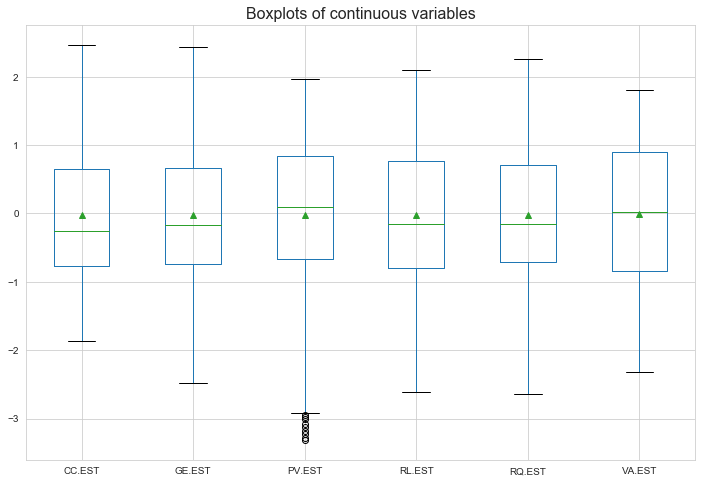

In [32]:
#Use boxplots to find 
full_df.boxplot(figsize=(12,8),showmeans=True)
plt.title('Boxplots of continuous variables', fontsize=16)
plt.show()

From the descriptive statics table and the boxplot, it seams that all of the variables have been already scaled and centered around cero. The ony feature that contains outliers is PV.EST (Political Stability and Absence of Violence), this will require further analysis. The means are very close to the medians, with a somewhat symmetric distribution in all variables, this could mean that teh variables might be normally distributed. Let's continue to handle th eputliers in the 'PV.EST' variable.

In [33]:
full_df[full_df['PV.EST']<-2.85]

,date,Country Name,Region,Income Group,CC.EST,GE.EST,PV.EST,RL.EST,RQ.EST,VA.EST,rating,agency
1084,2004-01-01,Iraq,Middle East & North Africa,Upper middle income,-1.484774,-1.592726,-3.180798,-1.828362,-1.646048,-1.643005,NaN,NaN
1164,2004-01-01,Somalia,Sub-Saharan Africa,Low income,-1.787207,-2.052327,-2.880443,-2.268273,-2.305674,-1.811016,NaN,NaN
1776,2007-01-01,Somalia,Sub-Saharan Africa,Low income,-1.759850,-2.226296,-3.224753,-2.405955,-2.531158,-1.848487,NaN,NaN
1980,2008-01-01,Somalia,Sub-Saharan Africa,Low income,-1.868714,-2.402195,-3.280530,-2.606445,-2.645041,-1.893330,NaN,NaN
2185,2009-01-01,Somalia,Sub-Saharan Africa,Low income,-1.715286,-2.228903,-3.314937,-2.447377,-2.555349,-2.039461,NaN,NaN
2390,2010-01-01,Somalia,Sub-Saharan Africa,Low income,-1.739246,-2.208117,-3.130971,-2.406111,-2.388267,-2.010569,NaN,NaN
2596,2011-01-01,Somalia,Sub-Saharan Africa,Low income,-1.706142,-2.140683,-3.083847,-2.332797,-2.377578,-2.015529,NaN,NaN
2802,2012-01-01,Somalia,Sub-Saharan Africa,Low income,-1.591648,-2.200339,-2.860755,-2.423379,-2.253568,-2.196764,NaN,NaN
3432,2015-01-01,Syrian Arab Republic,Middle East & North Africa,Low income,-1.545719,-1.590413,-2.974081,-1.423044,-1.635518,-1.922481,NaN,NaN
3638,2016-01-01,Syrian Arab Republic,Middle East & North Africa,Low income,-1.572115,-1.818922,-2.916323,-1.990615,-1.666154,-1.986811,NaN,NaN


The outliers in the dataset, do not contain any ratings. Hence, it is safe to drop them from the dataset. Let's proceed by perforing a Shapiro-Wilk normality test and pair it with its respective QQ-Plot.

In [34]:
full_df=full_df[full_df['PV.EST']>-2.85]

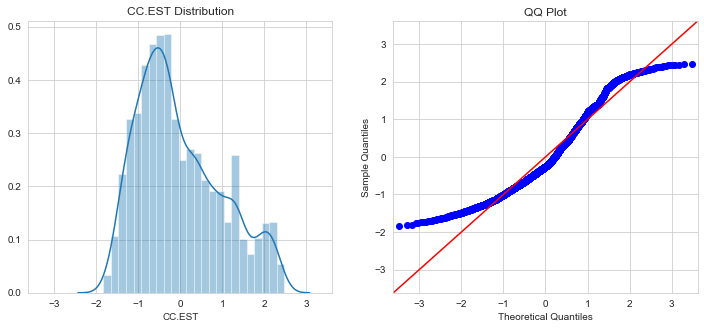

Shapiro-Wilk Test Statistics=0.950, p=0.000
CC.EST  does not look Gaussian (reject H0)


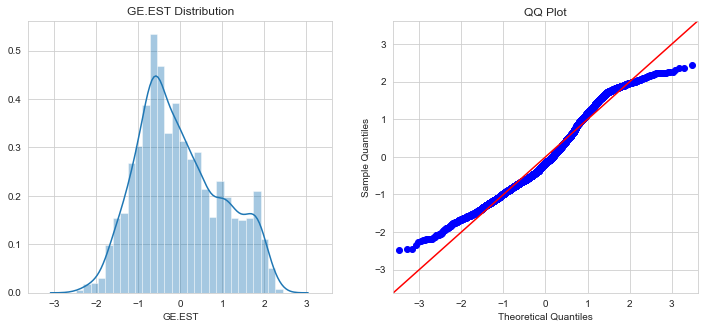

Shapiro-Wilk Test Statistics=0.973, p=0.000
GE.EST  does not look Gaussian (reject H0)


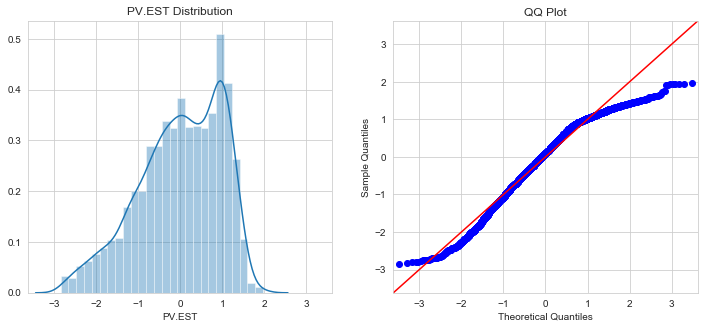

Shapiro-Wilk Test Statistics=0.963, p=0.000
PV.EST  does not look Gaussian (reject H0)


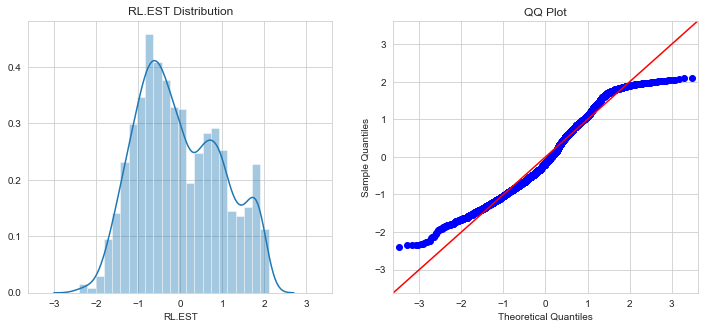

Shapiro-Wilk Test Statistics=0.971, p=0.000
RL.EST  does not look Gaussian (reject H0)


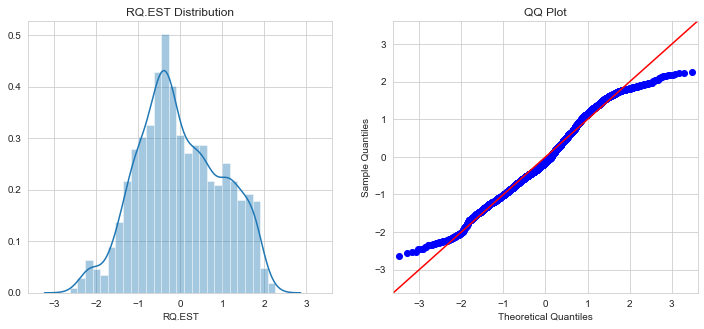

Shapiro-Wilk Test Statistics=0.985, p=0.000
RQ.EST  does not look Gaussian (reject H0)


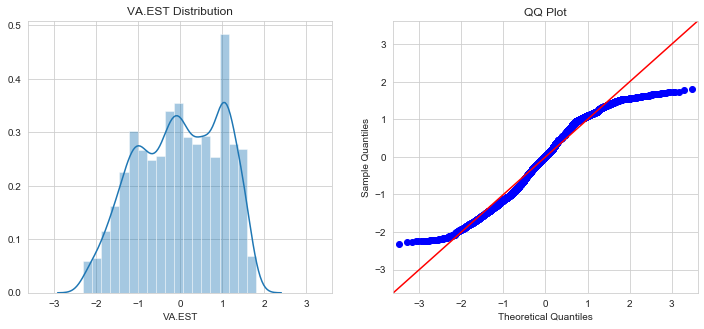

Shapiro-Wilk Test Statistics=0.967, p=0.000
VA.EST  does not look Gaussian (reject H0)


In [35]:
#Get numerical features column names
cont_cols = full_df.describe().columns
#Plot each of the features' distributions and test for normality
plot_histkde(full_df, cont_cols)

Even though the Shapiro-Wilk test rejected the null hypothesis and concluded that none of the variables is normally distributed. I believe they are normal enough for the goal of the proyect so far. Moreover,  I will just use classification models that do not require normally distributed features.

### 5.1 World at a Glance

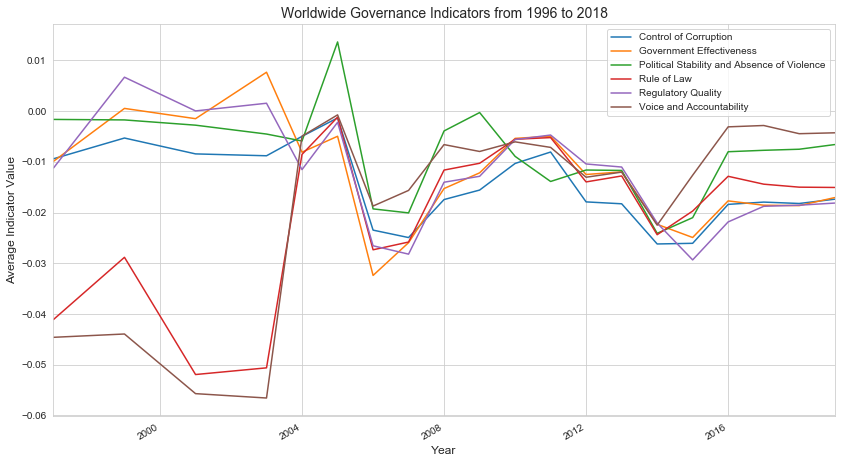

In [36]:
#Resample annual country governance indicators and plot a line graph.
world_df=full_df.set_index('date').resample('Y').mean().dropna().copy()
world_df.plot(figsize=(14,8))
plt.title("Worldwide Governance Indicators from 1996 to 2018", fontsize=14)
plt.ylabel('Average Indicator Value', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.legend(loc=1, bbox_to_anchor=(1.00, 1.00),
           labels=('Control of Corruption','Government Effectiveness','Political Stability and Absence of Violence',
                  'Rule of Law','Regulatory Quality','Voice and Accountability'))
plt.show();

The World Bank developed The Worldwide Governance Indicators in 1996, this is when the highest values for most indicators with average values close to 0, except for 'RL.EST' and 'VA.EST', Rule of Law and Voice and Accountability respectively, which started with the lowest observed values. They converge around year 2004 and shortly after that, they all together decrease drastically around year 2006. In more recent years, from 2016 onwards, the indicators show reduced volatility and more stable average values.

## 5.2 Comparing Governance Indicators according to Rating Grades

Now, let's dive into exploring how contry governance indicators differe when controlling for rating grade.

In [37]:
#Display how many unique ratings in the dataset
print('Number of unique ratings: ',full_df.rating.nunique())
full_df.rating.value_counts()

Number of unique ratings:  46


B       134
B+      122
BB-     121
BBB-    119
AAA     111
BBB      88
BB+      79
BBB+     75
A+       71
A-       62
B-       56
A        53
BB       53
AA       53
B1       37
B2       32
AA+      31
B3       30
AA-      30
Ba1      24
Baa3     23
Baa2     21
Ba3      19
Aaa      17
Caa1     16
A1       16
A2       15
Baa1     14
Aa3      14
Ba2      14
A3       13
CCC      12
Aa2      12
CCC+     10
Caa2      6
Aa1       6
SD        5
Caa3      5
C         3
CC        3
RD        3
NR        2
WR        1
CCC-      1
DDD       1
D         1
Name: rating, dtype: int64

In [38]:
### Create dictionary for replacement values.
valid_ratings.Grade.replace('In default with little prospect for recovery', 'In default', inplace=True)
grades=list(valid_ratings.Grade.unique())
agencies=valid_ratings.columns[1:]
#Instantiate dictionary of replacement values
ratingsgrades_dict={}
#For-loop to assign each of the valid ratings its grade value.
for grade in grades:
    temp = valid_ratings[valid_ratings['Grade']==grade][agencies]
    for agency in agencies:
        if len(temp[agency].dropna().values)>0:
            ind_ratings = temp[agency].dropna().values
            for rating in ind_ratings:
                ratingsgrades_dict[rating]=grade
ratingsgrades_dict

{'Aaa': 'Prime',
 'AAA': 'Prime',
 'Aa1': 'High Grade',
 'AA+': 'High Grade',
 'Aa2': 'Upper medium grade',
 'Aa3': 'Upper medium grade',
 'A1': 'Upper medium grade',
 'A2': 'Upper medium grade',
 'A3': 'Upper medium grade',
 'AA': 'Upper medium grade',
 'AA-': 'Upper medium grade',
 'A+': 'Upper medium grade',
 'A': 'Upper medium grade',
 'A-': 'Upper medium grade',
 'Baa1': 'Lower medium grade',
 'Baa2': 'Lower medium grade',
 'Baa3': 'Lower medium grade',
 'BBB+': 'Lower medium grade',
 'BBB': 'Lower medium grade',
 'BBB-': 'Lower medium grade',
 'Ba1': 'Non-investment grade speculative',
 'Ba2': 'Non-investment grade speculative',
 'Ba3': 'Non-investment grade speculative',
 'BB+': 'Non-investment grade speculative',
 'BB': 'Non-investment grade speculative',
 'BB-': 'Non-investment grade speculative',
 'B1': 'Highly speculative',
 'B2': 'Highly speculative',
 'B3': 'Highly speculative',
 'B+': 'Highly speculative',
 'B': 'Highly speculative',
 'B-': 'Highly speculative',
 'Caa1': 

Now instead of 26+ categories, we narrowed it to 9 since 'Not rated' is not a valid category. It is very evident when a country does not receive a rating. I wil further reduce the category count to 8 by including the 'In default' category as 'Extremely speculative". This is following the same reasoning as a 'Not rated' rating. It is self-evident when a country deafaults, tehre is no need for an agency to report the rating, since that would be disclosed by current unpaid creditors.

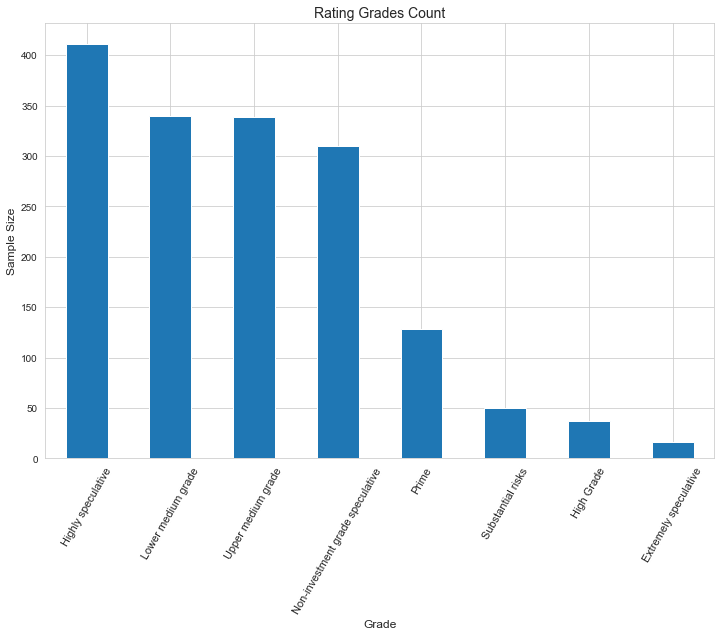

In [39]:
#Replace ratings and store dataframe with replaced ratings as grades_df
grades_df = full_df.copy()
grades_df['rating']=grades_df['rating'].replace(ratingsgrades_dict)
#Assigning 'Not rated' grades as np.nan, since it is equivalent as a missing value (not having a rate)
grades_df['rating']=grades_df['rating'].replace('Not rated',np.nan)
#Assigning 'In default' grades as 'Extremely specuative', since it is very evident when a country defaults.
grades_df['rating']=grades_df['rating'].replace('In default','Extremely speculative')
#Create a bar plot to see how many observations there are for each grade
grades_df['rating'].value_counts().plot(kind='bar', figsize=(12,8))
plt.title('Rating Grades Count', fontsize=14)
plt.ylabel('Sample Size',fontsize=12)
plt.xlabel('Grade', fontsize=12)
plt.xticks(rotation='60',fontsize=11)
plt.show();

In [40]:
grades_df=grades_df[grades_df.rating.notna()]
print('Observations per grade\n', grades_df.rating.value_counts())

Observations per grade
 Highly speculative                  411
Lower medium grade                  340
Upper medium grade                  339
Non-investment grade speculative    310
Prime                               128
Substantial risks                    50
High Grade                           37
Extremely speculative                16
Name: rating, dtype: int64


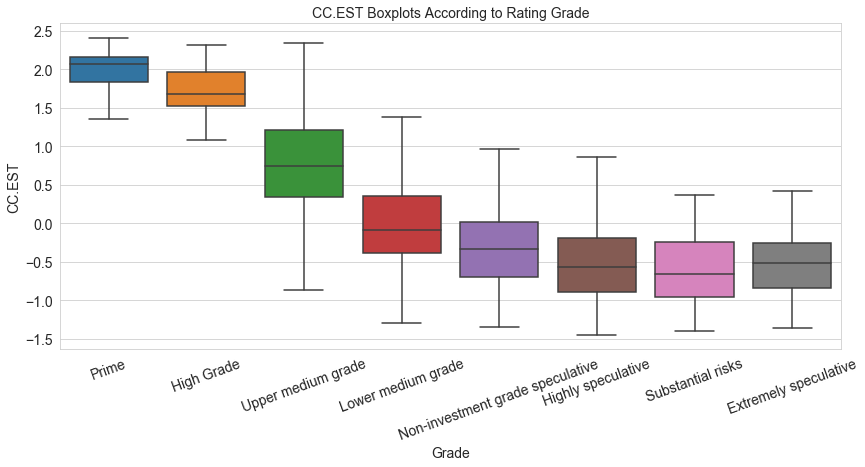

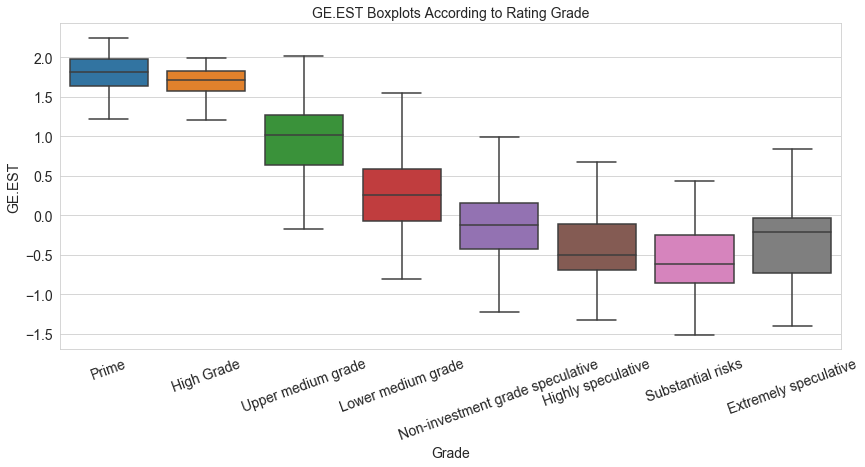

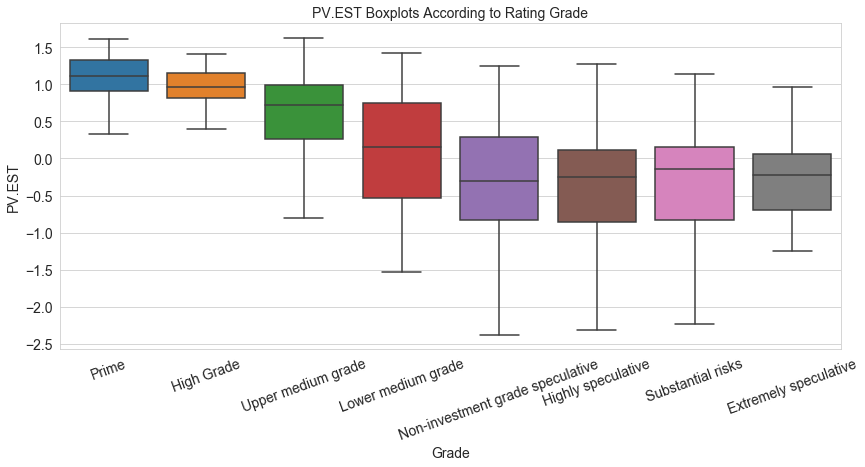

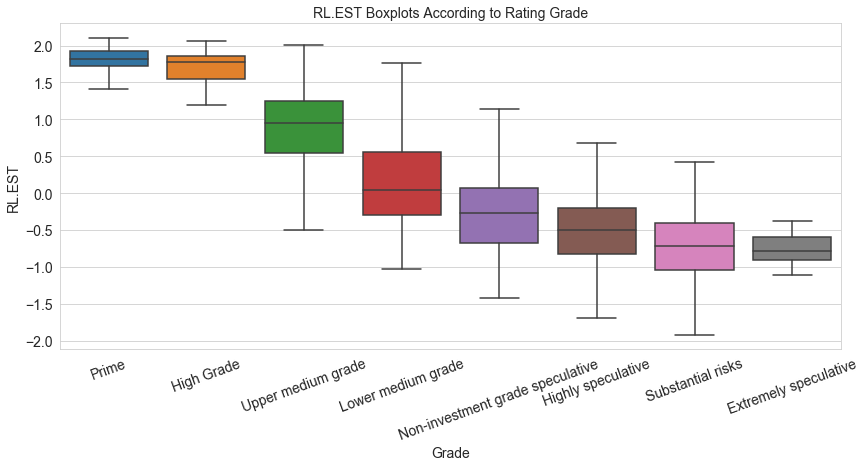

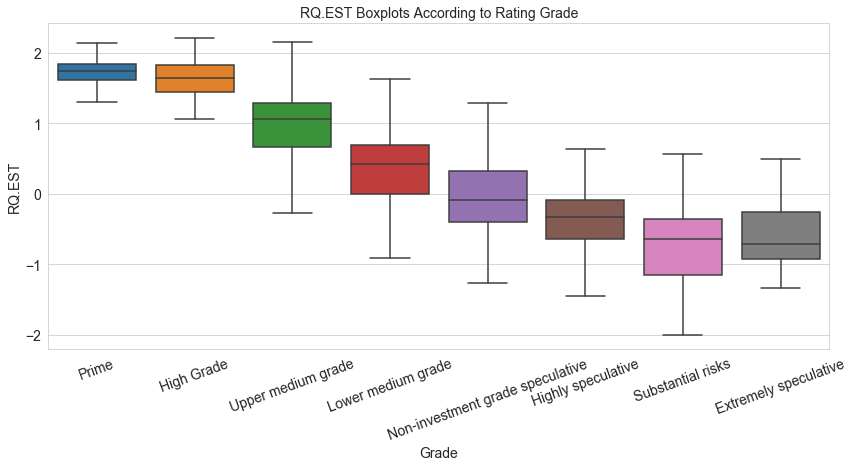

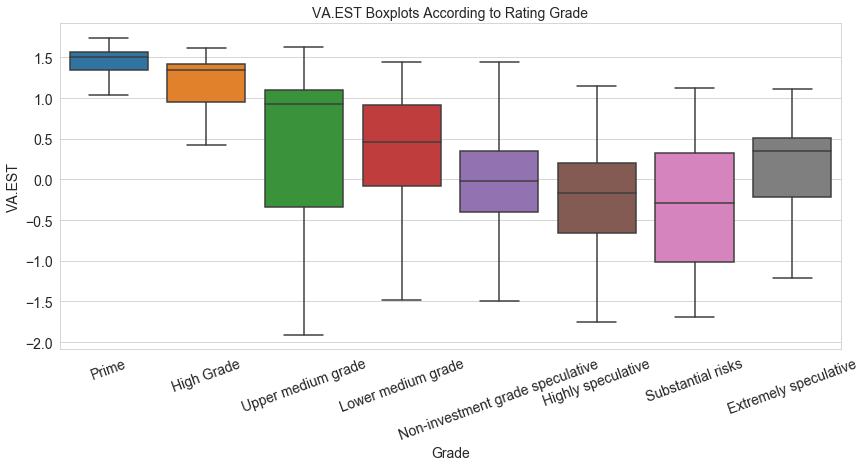

In [41]:
#Get list of grades in descending order of risk
grades=list(valid_ratings.Grade.replace('In default','Extremely speculative').unique()[:-1])
#Create box plots for each of the governance indicators 
for col in cont_cols:
    plt.figure(figsize=(14, 6))
    sns.boxplot(x='rating', y=col, data=grades_df,order=grades, showfliers=False)
    plt.title(col+' Boxplots According to Rating Grade', fontsize=14)
    plt.ylabel(col, fontsize=14)
    plt.xlabel('Grade', fontsize=14)
    plt.xticks(rotation='20',fontsize=14)
    plt.yticks(fontsize=14)
    plt.show();

## 5.3 How do different income levels differ in governance indicators?

In [42]:
#Get a new dataframe containing 2018 values only
twenty18_df=grades_df[grades_df['date']=='2018']
twenty18_df['Income Group'].unique()

array(['Upper middle income', 'High income', 'Lower middle income',
       'Low income'], dtype=object)

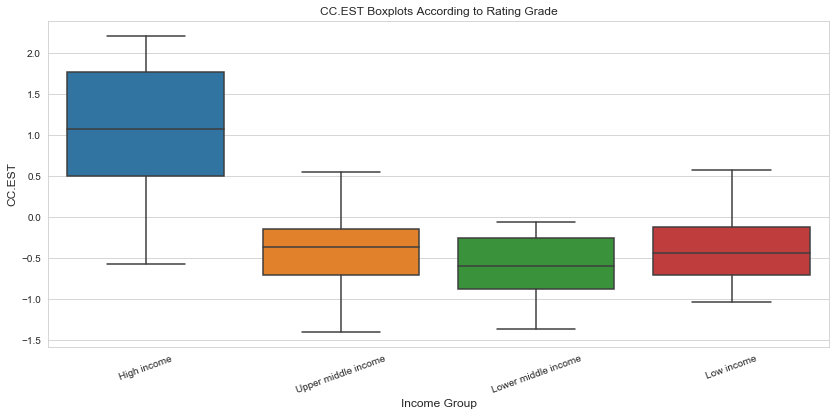

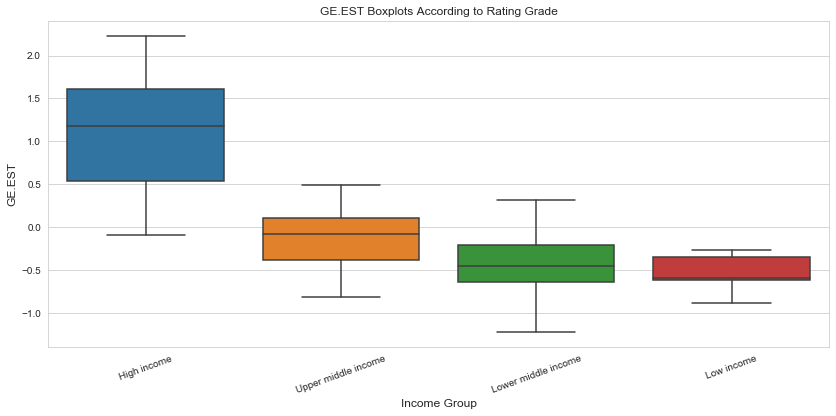

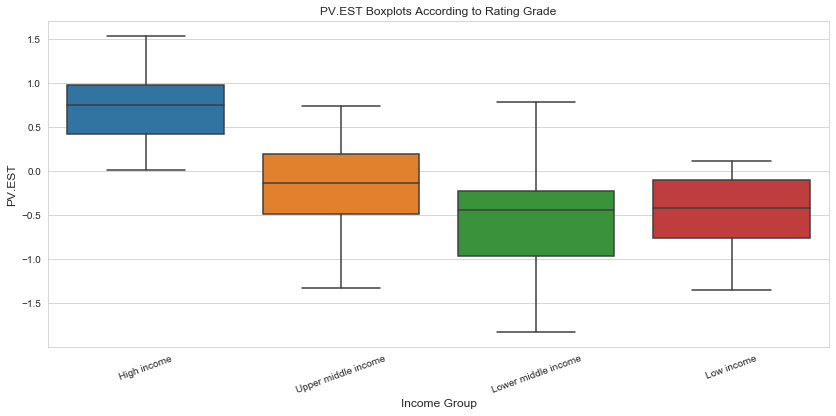

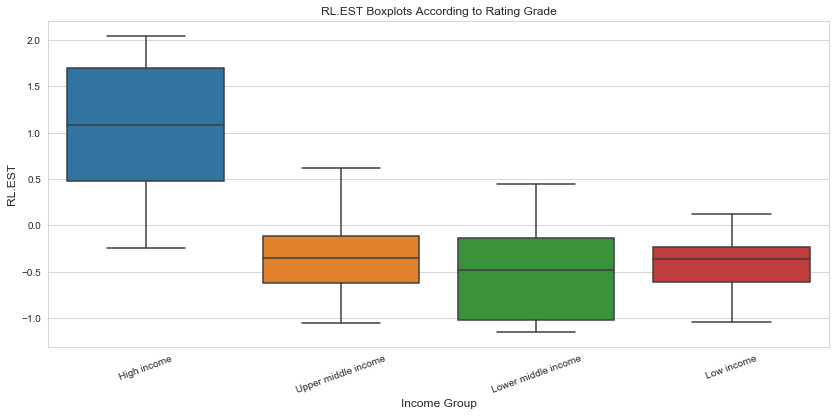

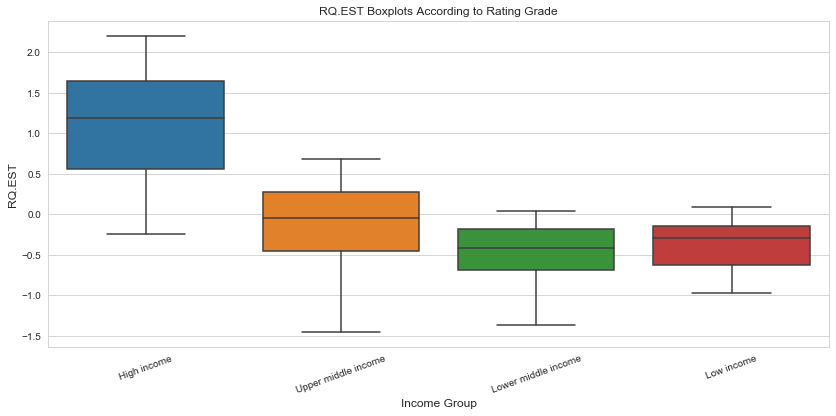

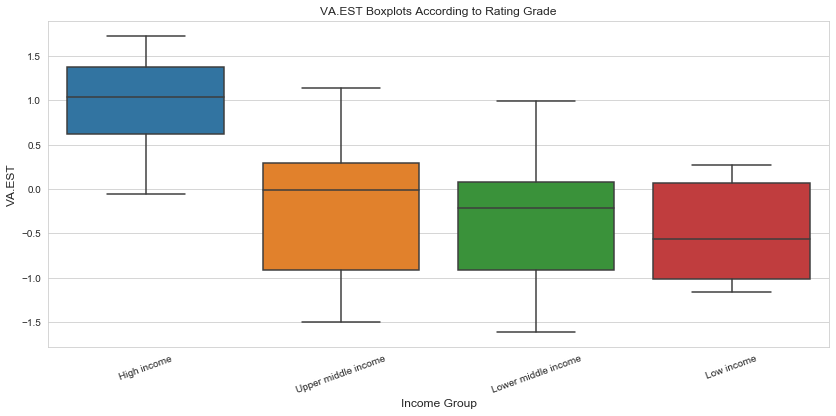

In [43]:
#Instantiate a list with the correct income level order
income_order=['High income','Upper middle income','Lower middle income','Low income']
#Create boxplots for each of the WGI for each of the income level groups.
for col in cont_cols:
    plt.figure(figsize=(14, 6))
    sns.boxplot(x='Income Group', y=col, data=twenty18_df, order=income_order,showfliers=False)
    plt.title(col+' Boxplots According to Rating Grade')
    plt.ylabel(col, fontsize=12)
    plt.xlabel('Income Group', fontsize=12)
    plt.xticks(rotation='20')
    plt.show();

Fpr the most part, we see a decreasing pattern, as we would expect. This is also similar to the boxplots obtained when controlling for rating grade. It is evident that the difference in high income against the 3 other groups is much larger that the differences among 3 other groups. 

## 5.3 How are Rating Grades Allocated per Region?

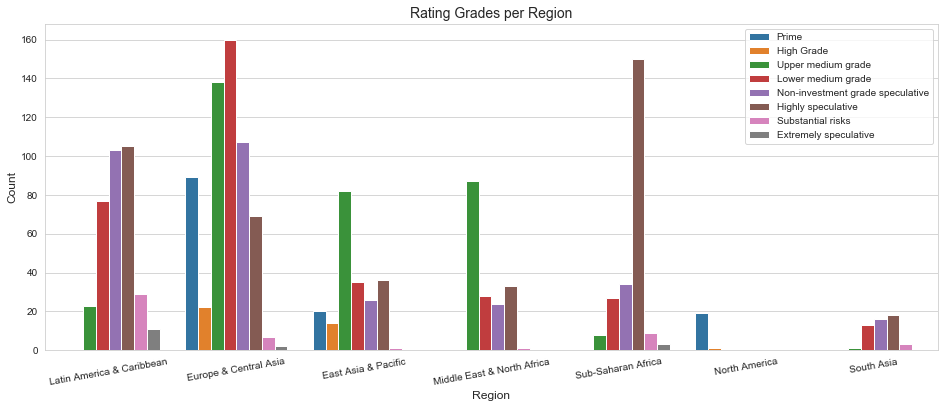

In [44]:
plt.figure(figsize=(16, 6))
sns.countplot(x="Region", hue="rating", data=grades_df, hue_order=grades)
plt.title("Rating Grades per Region", fontsize=14)
plt.ylabel('Count',fontsize=12)
plt.xlabel('Region', fontsize=12)
plt.xticks(rotation='10')
plt.legend(loc='upper right')
plt.show();

There are ony 3 regions with prime rating grades, North America, Europe and Central Asia, and East Asia Pacific. Sub-Saharan Africa has the most highly sepculative rating grades of all regions. South Asia is mostly awardaded lower medium grades downward. All regions, except North America, have no-investment grade speculative rating grades.

We have already had interesting findings regarding the dataset. Now, it is turn to switch our attention towards beuilding a predictive model that can accurately predict the rating grade given governance indicators.

## 6. The Classification Models
I will begin by one-hot-coding the regions variable, followed by label encoding the rating grades. After that I will split both dataframes into features and target, to start building my train and test datasets.
### 6.1 Data Prepping

In [45]:
#Instantiate the dataframe that will be used for the model.
#Get a adatframe containing features and target variables.
model_df = grades_df.drop(['date','Income Group','Country Name','agency'], axis=1)
#Dataframe with only features
features=model_df.drop('rating', axis=1)
#One-hot-coding the regions
features = pd.get_dummies(features,drop_first=True)
#Isntantiate a dataframe just containing the target variable
target=model_df.rating
#Label encoding the rating grades
le = preprocessing.LabelEncoder()
le.fit(target)
target = le.transform(target)
#Return the target variable to a pandas dataframe to keep indexing consistent
target=pd.DataFrame(data=target,columns=['target'])

In [46]:
#View the first 5 rows
print(target.head())
features.head()

   target
0       4
1       7
2       4
3       2
4       2


,CC.EST,GE.EST,PV.EST,RL.EST,RQ.EST,VA.EST,Region_Europe & Central Asia,Region_Latin America & Caribbean,Region_Middle East & North Africa,Region_North America,Region_South Asia,Region_Sub-Saharan Africa
6,-0.101317,0.165690,0.112986,0.075553,0.518067,0.391903,0,1,0,0,0,0
11,1.156810,1.373242,1.070221,1.146361,0.967724,1.102839,0,1,0,0,0,0
14,1.542726,1.414038,1.048930,1.046773,1.288828,1.342969,0,1,0,0,0,0
24,-0.018579,-0.143134,-0.218181,-0.223502,0.296933,0.242077,0,1,0,0,0,0
26,-0.361505,-0.042585,-0.090678,-0.344958,-0.184435,0.428986,1,0,0,0,0,0


In [47]:
#Get info on features
features.info()
print('\nMissing Values:\n',features.isna().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1631 entries, 6 to 4076
Data columns (total 12 columns):
CC.EST                               1621 non-null float64
GE.EST                               1621 non-null float64
PV.EST                               1631 non-null float64
RL.EST                               1626 non-null float64
RQ.EST                               1621 non-null float64
VA.EST                               1631 non-null float64
Region_Europe & Central Asia         1631 non-null uint8
Region_Latin America & Caribbean     1631 non-null uint8
Region_Middle East & North Africa    1631 non-null uint8
Region_North America                 1631 non-null uint8
Region_South Asia                    1631 non-null uint8
Region_Sub-Saharan Africa            1631 non-null uint8
dtypes: float64(6), uint8(6)
memory usage: 178.8 KB

Missing Values:
 CC.EST                               10
GE.EST                               10
PV.EST                                0
RL.EST 

There are some missing values in the data, I will fit 2 different imputers and see which one performs best on the data. For now, let's look at how a correlation heatmap looks for our data.

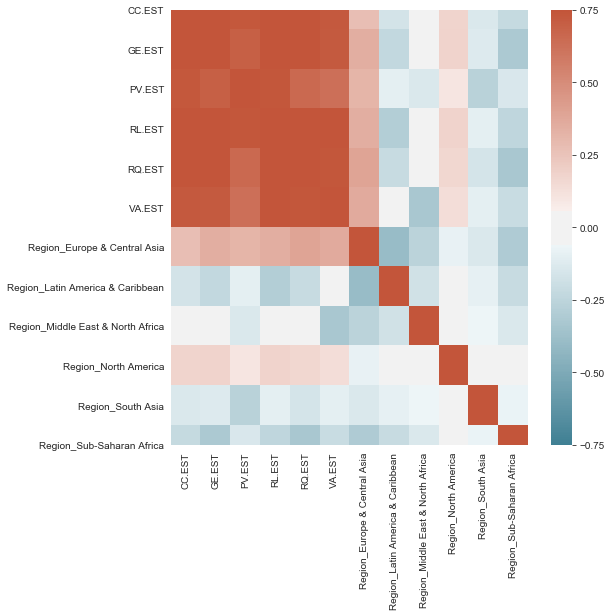

In [48]:
#Plot correlation heatmap
heatmap(features)

It is not surprising to find out that governance indicators are highly correlated among each other. The only two that do not seem so highly correlated are VA.EST and PV.EST, Voice and Accountability and Political Stability respectively. Also, it is interesting that regions with higher rating grades such as North America and Europe & Central Asia, have a meaningful positiv ecorrelation with the goverance indicators. And, in the other hand, a region like Sub-Saharan Africa has a meaningful negative correlation with the governance indicators.

Since I will be using non-parametric classification models, there is no need to make any transformations to the data in order to reduce multicollinearity among the feature variables. Now let's proceed to evalute 2 different imputer methods on the data and choose the best performing one.

In [49]:
knn_scores=[]
iterative_scores=[]
for n in [5,7,9]:
    # Instantiate imputer method for knearneaighbors imputer
    imputer = KNNImputer(missing_values=np.nan,n_neighbors=n)
    #Get imputer score on full dataset
    knn_impute_scores = imputer_scores(imputer, features, target, n_splits=10, scoring='precision_macro')
    knn_scores.append(knn_impute_scores.mean())

    #Instantiate imputer method foor iterative imputer
    imputer = IterativeImputer(missing_values=np.nan,random_state=123,
                           n_nearest_features=n,sample_posterior=True)
    #Get imputer score on full dataset
    iterative_impute_scores = imputer_scores(imputer,features, target,n_splits=10,scoring='precision_macro')
    iterative_scores.append(iterative_impute_scores.mean())

#Get the results into a data frame for comparison
imputer_results=pd.DataFrame([knn_scores, iterative_scores],
                      index= ['knn','iterative'],
                           columns=['n=5','n=7','n=9'])
imputer_results.transpose()

,knn,iterative
n=5,0.617200,0.599010
n=7,0.598444,0.627178
n=9,0.626895,0.624718


The Iterative Imputer performs better using 7 nearest features. From sklearn's documentation, it does say that the iterative imputer performs best with normally distributed data. Probably tha fat that teh data is scaled, centrally distributed around 0, helps to the performance of this imputer. Now that we know what imputer to use it is time to llok out our target incidence rate and check how balanced is the target variable.

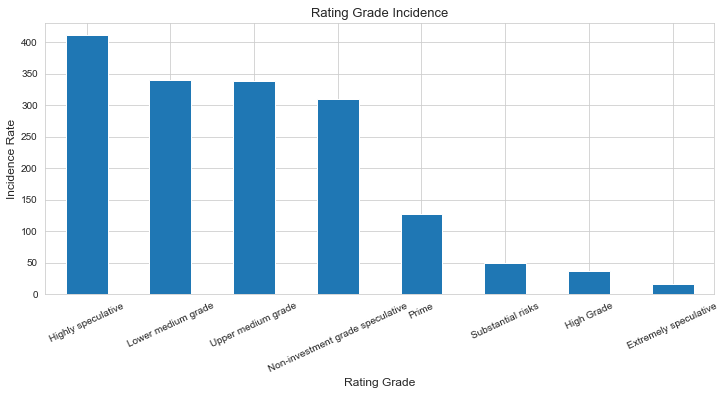

In [50]:
incidence=pd.DataFrame(data=le.inverse_transform(target),columns=['target'])
incidence.target.value_counts().plot(kind='bar', figsize=(12,5))
plt.title('Rating Grade Incidence', fontsize=13)
plt.ylabel('Incidence Rate', fontsize=12)
plt.xlabel('Rating Grade', fontsize=12)
plt.xticks(rotation='25')
plt.show();

It seems that the data is highly imbalanced. A big concern at the moment is that the rating grade with less incidence is actually the one that matters the most, Extremely speculative. Substantial risks grade is also one of the grades with lowest target incidence, and a very important grade not to miss. To solve this issue I will use SMOTE-NC given that the features also contain categorical data. First, let's fit the full dataset with imputed values using the baseline_models functions. Then again after using SMOTE-NC to see any improvements in scores.

In [51]:
#Create final train and test sets stratified according to the target variable. 
X_train, X_test, y_train, y_test = train_test_split(features,target, test_size = 0.25,
                                                    stratify=target,random_state=123)
#Instantiate KNN Imputer
imputer = IterativeImputer(missing_values=np.nan,random_state=123,
                           n_nearest_features=7,sample_posterior=True)
#Impute missing values in train and test sets
X_imptr = imputer.fit_transform(X_train)
X_impte = imputer.transform(X_test)
#Obtain scores
results=baseline_models(X_imptr, y_train, X_impte, y_test, verbose=False)
results.sort_values('precision', ascending=False)

,accuracy,precision,recall
GradientBoosting,0.674020,0.549746,0.497485
RandomForest,0.723039,0.522754,0.506815
KNeighbors,0.678922,0.503630,0.480353


Using plain vanilla models, Gradient Boosting does have a better precision score. However, Random Forests are a very close second with higher accuracy and higher recall. Let's see how this hold after hyperparameter tunning, since differences might become more obvious.

In [52]:
#Get the index for the categorical features
cat_col_index = list(range(len(features.columns)-6,len(features.columns)))
#Instantiate dictionary to over-sample minority variables
#smote_dict={0: 100, 1:100,6:100}
#Instantiate SMOTENC method
sm = SMOTENC(categorical_features=cat_col_index, random_state=123)
#Fit and resampe SMOTE-NC on train dataset
X_trainres, y_trainres = sm.fit_resample(X_imptr, y_train)

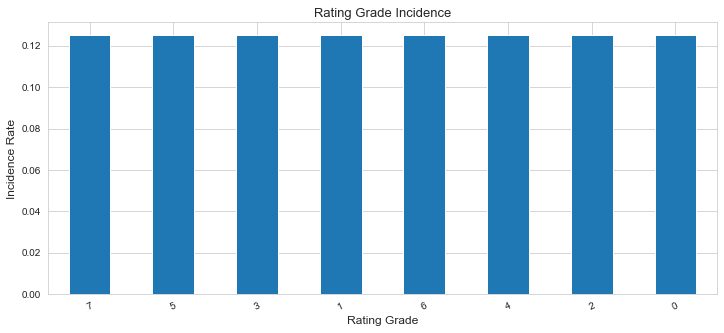

In [53]:
incidence=pd.DataFrame(data=y_trainres,columns=['target'])
incidence.target.value_counts(normalize=True).plot(kind='bar', figsize=(12,5))
plt.title('Rating Grade Incidence', fontsize=13)
plt.ylabel('Incidence Rate', fontsize=12)
plt.xlabel('Rating Grade', fontsize=12)
plt.xticks(rotation='25')
plt.show();

In [54]:
results=baseline_models(X_trainres, y_trainres, X_impte, y_test, verbose=False)
results.sort_values('precision', ascending=False)

,accuracy,precision,recall
RandomForest,0.674020,0.532182,0.503677
KNeighbors,0.639706,0.496254,0.511884
GradientBoosting,0.595588,0.471501,0.458907


By balancing the dataset with synthetic data, the overall scores actually went a little down, except for recall, which is great. I beleive it is a good compromise in order to get a balanced dataset that will make the interpratation of precision and recall scores a bit more intuitive when getting the results from the optimized models.

### 6.1 Hyperparameter Tuning
Now that the data is ready for modelling, I will create the dictionaries that will include the information on the classifiers to use and the different values for their hyperparameters.

In [62]:

#Create pipeline for each of the classifiers.
pipelines = {'knn':Pipeline([('imputer', IterativeImputer(missing_values=np.nan,random_state=123,
                                                          sample_posterior=True)),
                             ('clf', KNeighborsClassifier())]),
            'randomforest':Pipeline([('imputer', IterativeImputer(missing_values=np.nan,random_state=123,
                                                          sample_posterior=True)),
                                     ('clf', RandomForestClassifier(random_state=123))]),
            'gradientboosting': Pipeline([('imputer', IterativeImputer(missing_values=np.nan,random_state=123,
                                                          sample_posterior=True)),
                                          ('clf', GradientBoostingClassifier(random_state=123))]),
            }

#Define Hyperparameters for each pipeline
hyperparameters_knn ={'imputer__n_nearest_features': [3,5, 7],
                     'clf__n_neighbors': [6,7,8],
                     'clf__weights':['uniform','distance']}

hyperparameters_rf ={'imputer__n_nearest_features': [3,5,7],
                     'clf__n_estimators': [120,150],
                     'clf__criterion': ['entropy', 'gini'], 
                     'clf__max_depth': [6,7,8],  
                     'clf__min_samples_leaf':[0.01,0.02,0.03],  
                     'clf__min_samples_split':[0.01,0.02,0.03]}

hyperparameters_gb ={'imputer__n_nearest_features': [5, 7, 9],
                     'clf__n_estimators': [120,150], 
                     'clf__max_depth': [5,7,9],  
                     'clf__learning_rate': [0.07,0.1,0.15]}

#Instantiate hyperparapeter dictionary
hyperparameters = {'knn':hyperparameters_knn,
                   'randomforest':hyperparameters_rf,
                   'gradientboosting': hyperparameters_gb}

In [63]:
fitted_prec= grid_pipe(pipelines, hyperparameters, X_trainres, y_trainres, 
                       X_test, y_test, cv=10,scoring='precision_macro', display=True)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   13.6s finished


The knn model has been fitted.
Best score: 0.854
Best params:
 {'clf__n_neighbors': 6, 'clf__weights': 'distance', 'imputer__n_nearest_features': 3} 

Fitting 10 folds for each of 324 candidates, totalling 3240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 3240 out of 3240 | elapsed:  9.7min finished


The randomforest model has been fitted.
Best score: 0.703
Best params:
 {'clf__criterion': 'entropy', 'clf__max_depth': 8, 'clf__min_samples_leaf': 0.01, 'clf__min_samples_split': 0.01, 'clf__n_estimators': 150, 'imputer__n_nearest_features': 3} 

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   54.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 19.4min finished


The gradientboosting model has been fitted.
Best score: 0.851
Best params:
 {'clf__learning_rate': 0.1, 'clf__max_depth': 7, 'clf__n_estimators': 150, 'imputer__n_nearest_features': 5} 



In [64]:
precision_recall_fscore_scores=[]
for name, model in fitted_prec.items():
    test_preds=model.predict(X_test)
    precision,recall,fscore,support = precision_recall_fscore_support(y_test, test_preds, average='macro')
    accuracy = accuracy_score(y_test, test_preds)
    precision_recall_fscore_scores.append((name,accuracy,precision,recall,fscore))
scores=pd.DataFrame(data=precision_recall_fscore_scores, columns=['name','accuracy','precision',
                                                    'recall','fscore']).sort_values('precision',ascending=False)
scores

,name,accuracy,precision,recall,fscore
0,knn,0.656863,0.514529,0.522831,0.514907
2,gradientboosting,0.669118,0.499674,0.502513,0.499786
1,randomforest,0.544118,0.423667,0.414191,0.413206


In [65]:
confusion_matrix(fitted_prec['knn'].predict(X_test),y_test)

array([[ 0,  0,  5,  0,  3,  0,  3,  0],
       [ 0,  5,  0,  1,  0,  3,  0,  2],
       [ 2,  0, 62,  1, 10,  0,  5,  0],
       [ 1,  0,  2, 60, 20,  0,  1,  8],
       [ 0,  0, 17,  8, 41,  0,  2,  2],
       [ 0,  3,  0,  0,  0, 28,  0,  3],
       [ 1,  0, 17,  1,  2,  0,  1,  0],
       [ 0,  1,  0, 14,  2,  1,  0, 70]])

KNearestNeighbors model, is the best performing model of the three. Gradient boosting is a very close second. By tuning the hyperparameters the KNN's precision score went from 49% to a little more than 66%. Let's look at the confusion matrix. From the confusion matrix, we can see that one of the rating grades did not get any true positives, it is very likely to be one of the rating grades with fewest observations. So we have to proceed with caution when using the predicted values. KNN does not have a feature importances method to see which efeatures are most relevant. hence, I will use the gradient bssting classifier to get the importance of this features.

In [59]:
clf=GradientBoostingClassifier(learning_rate=0.1,max_depth=5,n_estimators=120)
clf.fit(X_imptr,y_train)
clf.feature_importances_

array([0.10266114, 0.14325503, 0.10615315, 0.22454504, 0.20542256,
       0.15851453, 0.01710291, 0.0058393 , 0.00822283, 0.00654528,
       0.00433681, 0.01740142])

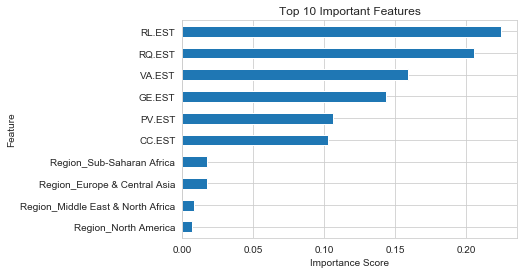

In [60]:
plot_feat_importance(clf,X_train.columns)

It was to be expected that the most important features were the worldwide governance indicators.

### 6.3 2018 Predictions

In [61]:
pred_2018=full_df[full_df.date=='2018'].copy()
pred_2018=pred_2018[pred_2018.rating.isna()]
X_2018= pred_2018.drop(['date', 'Country Name', 'Income Group', 'rating','agency'], axis=1)
X_2018=pd.get_dummies(X_2018,drop_first=True)
X_2018imp=pd.DataFrame(imputer.transform(X_2018),index=X_2018.index, columns=X_2018.columns)
ypred_2018=pd.DataFrame(le.inverse_transform(fitted_prec['knn'].predict(X_2018imp))
                        ,index=X_2018.index, columns=['rating'])
pred_results=pd.merge(pred_2018,ypred_2018,left_index=True,right_index=True)
pred_results[['Country Name','Region','Income Group','rating_y']].to_csv('data/2018predictions.csv')
pred_results[['Country Name','Region','Income Group','rating_y']].head(20)

,Country Name,Region,Income Group,rating_y
3872,Afghanistan,South Asia,Low income,Highly speculative
3874,Algeria,Middle East & North Africa,Upper middle income,Highly speculative
3875,American Samoa,East Asia & Pacific,Upper middle income,Lower medium grade
3878,Antigua and Barbuda,Latin America & Caribbean,High income,Extremely speculative
3881,Aruba,Latin America & Caribbean,High income,Lower medium grade
3887,Bangladesh,South Asia,Lower middle income,Non-investment grade speculative
3893,Bermuda,North America,High income,Upper medium grade
3894,Bhutan,South Asia,Lower middle income,Non-investment grade speculative
3896,Bosnia and Herzegovina,Europe & Central Asia,Upper middle income,Highly speculative
3897,Botswana,Sub-Saharan Africa,Upper middle income,Upper medium grade


## 7. Conclusion and Recommendations
I have developed a KNearestNeighbors Classification model that has about 66% precision. It is a significant score given that there are 7 different classes and the most popular one only had about 25% incidence.

This model does not substitute for due dilligence or more complete current models. This model could be thouhgt as a feature engineering tool to be used during preprocessing to develop a new feature, in this case the rating grade, and use it to increase the more robust model's performance.